## Print out available UWLCM parameters

In [1]:
%%bash
module load GCC/11.3.0 OpenMPI/4.1.4-mpi-thread-multiple Boost.MPI/1.79.0-mpi-thread-multiple HDF5/1.12.2-threadsafe CMake/3.23.1 Blitz++/1.0.2 2>/dev/null
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/net/pr2/projects/plgrid/plgguwicmw/geolab/lib/" mpiexec -N 1 /net/pr2/projects/plgrid/plgguwicmw/geolab/bin/uwlcm --micro=lgrngn --help

General options:
  --micro arg                      one of: blk_1m, blk_2m, lgrngn, none
  --case arg (=moist_thermal)      one of: dry_thermal, moist_thermal, 
                                   dycoms_rf01, dycoms_rf02, 
                                   cumulus_congestus_icmw20, 
                                   cumulus_congestus_icmw24, rico11, dry_pbl
  --X arg (=-1)                    domain size in X [m] (set negative for case 
                                   default)
  --Y arg (=-1)                    domain size in Y [m] (set negative for case 
                                   default)
  --Z arg (=-1)                    domain size in Z [m] (set negative for case 
                                   default)
  --nx arg (=1)                    grid cell count in horizontal
  --ny arg (=0)                    grid cell count in horizontal, 0 for 2D 
                                   simulation
  --nz arg (=1)                    grid cell count in vertical
  --nt arg (=0) 

## Simulation

### Set simulation parameters

In [2]:
import os.path

In [3]:
outdir = os.path.expandvars("$SCRATCH/outdir/")

In [4]:
rt_params = {
    "outdir" : outdir,
    "case"   : "moist_thermal",
    "nx"     : "181",
    "ny"     : "0", # ny>0 makes the simulation 3D
    "nz"     : "121",
    "dt"     : "1",
    "nt"     : "600",
    "micro"  : "lgrngn",
    "outfreq": "30",
    "outwindow" : "1",
    "sgs"       : "1",
    "sd_conc"   : "100",
    "sstp_cond"  : "2",
    "sstp_coal"  : "2",
    "aerosol_conc_factor" : "1",
    "aerosol_independent_of_rhod" : "1",
    "backend" : "CUDA" # use multi_CUDA in case of multiple GPUs
}

# 91 x 91 x 61 nt 600 takes about 20 min on 16 cores and 1 GPU

# Converting dictionary to string
rt_params_str = " ".join(f"\-\-{k}={v}" for k, v in rt_params.items())

### Run the model

In [5]:
%%bash -s "{rt_params_str}"
module load GCC/11.3.0 OpenMPI/4.1.4-mpi-thread-multiple Boost.MPI/1.79.0-mpi-thread-multiple HDF5/1.12.2-threadsafe CMake/3.23.1 Blitz++/1.0.2 2>/dev/null
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/net/pr2/projects/plgrid/plgguwicmw/geolab/lib/" mpiexec -quiet -N 1 /net/pr2/projects/plgrid/plgguwicmw/geolab/bin/uwlcm ${1//\\}

[1737547522.483847] [t0043:3360911:0]           ib_md.c:1234 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1737547522.483869] [t0043:3360911:0]           ib_md.c:1235 UCX  WARN  IB: data corruption might occur when using registered memory.
[1737547522.548717] [t0043:3360911:0]           ib_md.c:1234 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1737547522.548735] [t0043:3360911:0]           ib_md.c:1235 UCX  WARN  IB: data corruption might occur when using registered memory.
wall time in milliseconds: 
loop:                            52052
  hook_ante_step:                  39061 (75.0423%)
    hook_mixed_rhs_ante_step:        3670 (7.05064%)
      async_wait:                    949 (1.82318%)
      sync:                            471 (0.904864%)
  step:                            1284 (2.46676%)
  hook_ante_delayed_step:          1450 (2.78568%)
    sync_wait:                       663 (1.27373%)
    asy

 wall time: 53.602s user time: 40.81s system time: 2.34s


CalledProcessError: Command 'b'module r uwlcm_ompi 2>/dev/null\nLD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/net/pr2/projects/plgrid/plgguwicmw/geolab/lib/" mpiexec -quiet -N 1 /net/pr2/projects/plgrid/plgguwicmw/geolab/bin/uwlcm ${1//\\\\}\n'' returned non-zero exit status 1.

## Result analysis

In [6]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import xrUWLCM as xrU
import math

#from xhistogram.xarray import histogram
import xarray as xr

In [7]:
# load the data
data, data_DSD = xrU.load_outdir(outdir)
data = xrU.calc_all(data).pipe(xrU.convert_units)

### Print DataSet content

In [8]:
data #variables of particular interest: nc, nr, rc, rr, cloud_r_mean, rain_r_mean, cloud_sigma, rain_sigma

<xarray.Dataset> Size: 68MB
Dimensions:                 (x: 181, z: 121, t: 21, xe: 182, ze: 122)
Coordinates:
  * xe                      (xe) float32 728B 0.0 20.0 40.0 ... 3.6e+03 3.62e+03
  * ze                      (ze) float32 488B 0.0 20.0 40.0 ... 2.4e+03 2.42e+03
  * x                       (x) float32 724B 10.0 30.0 ... 3.59e+03 3.61e+03
  * z                       (z) float32 484B 10.0 30.0 ... 2.39e+03 2.41e+03
  * t                       (t) float32 84B 0.0 0.008333 ... 0.1583 0.1667
Data variables: (12/68)
    G                       (x, z) float32 88kB dask.array<chunksize=(181, 121), meta=np.ndarray>
    T                       (t) float32 84B dask.array<chunksize=(1,), meta=np.ndarray>
    X                       (xe, ze) float32 89kB dask.array<chunksize=(182, 122), meta=np.ndarray>
    Z                       (xe, ze) float32 89kB dask.array<chunksize=(182, 122), meta=np.ndarray>
    hgt_fctr                (z) float32 484B dask.array<chunksize=(121,), meta=np.ndarray>
    mix_len                 (z) float32 484B dask.array<chunksize=(121,), meta=np.ndarray>
    ...                      ...
    cloud_r_mean            (t, x, z) float32 2MB dask.array<chunksize=(1, 181, 121), meta=np.ndarray>
    cloud_r_sigma           (t, x, z) float32 2MB dask.array<chunksize=(1, 181, 121), meta=np.ndarray>
    rain_r_mean             (t, x, z) float32 2MB dask.array<chunksize=(1, 181, 121), meta=np.ndarray>
    rain_r_sigma            (t, x, z) float32 2MB dask.array<chunksize=(1, 181, 121), meta=np.ndarray>
    dv                      (x, z) float32 88kB dask.array<chunksize=(181, 121), meta=np.ndarray>
    surf_area               float32 4B 3.6e+03
Attributes: (12/143)
    omp_max_threads (on MPI rank 0):  1.0
    microphysics:                     super-droplets
    aerosol_conc_factor:              uniform
    datadir:                          /net/tscratch/people/plgpdziekan/outdir/
    th_src:                           0.0
    rv_src:                           0.0
    ...                               ...
    kappa2:                           0.61
    relax_ccn:                        0.0
    vip_abs:                          expl
    aerosol definition:               rw < 0.5 microns
    cloud droplet definition:         0.5 microns < rw < 25 microns
    rain drop definition:             25 microns < rw

### Example plots

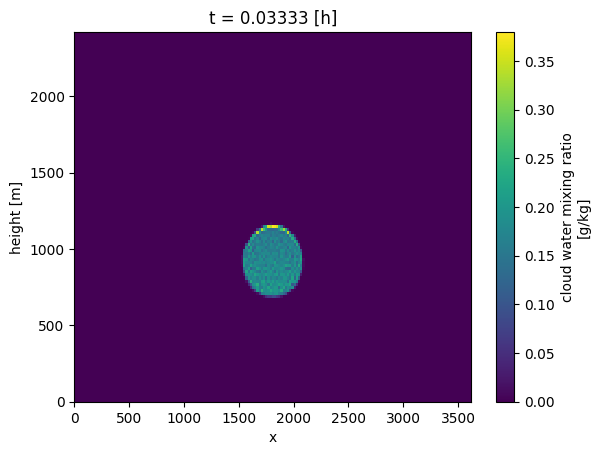

In [13]:
# slice through domain center (at y=1800 m) showing cloud water content at 600s
#data.rc.sel(t=360./3600, method='nearest').sel(y=3.6e3/2., method='nearest').plot(x='x')
data.rc.sel(t=120./3600, method='nearest').plot(x='x')